<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/03_TextImage/examples/Clustering_NLB_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clustering National Library Board Infopedia Articles

In this example, we will use clustering to explore the summaries of different articles published by the National Library Board about Singapore.

The hypothesis is that the words used in the text can separate the articles into different "topic" groups.

The use case is automatic topic suggestion for new articles.

Data Source: https://data.gov.sg/dataset/national-library-board-infopedia-articles

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# use stop words from nltk instead of sklearn as they are more reliable
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# clustering
from sklearn.cluster import KMeans

# visualisation (for sparse matrices)
from sklearn.decomposition import TruncatedSVD

# topic extraction
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('http://opendata.nlb.gov.sg/content/opds/datagovsg/sg-infopedia.csv')
df

,uid,book_title,subject,summary,original_publisher,digital_publisher,format,language,copyright,author_name,published,resource_url,cover,thumbnail
0,d129a114-12d1-456f-ba77-3c1fad52d9ab,17th APEC meeting,Events | Economy |nlbshtx:Events|nlbshtx:Econo...,Singapore hosted the 17th Asia-Pacific Economi...,na,National Library Board Singapore,text/html :. .,eng,na,na,na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
1,2dbdfae5-8e45-48da-87e0-5e8436a7ff44,17th century Singapore Straits,Politics and Government {18336134}|Geography a...,The Singapore Straits is among the most geogra...,na,National Library Board Singapore,text/html :. .,eng,na,na,na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
2,92bb56f0-e821-40d1-bd8c-cf8fa7e7f172,1819 Singapore Treaty,Politics and Government {18336134}|Events {184...,"On 6 February 1819, Sir Stamford Raffles, Teme...",na,National Library Board Singapore,text/html :. .,eng,na,na,na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
3,9590a69f-b3c8-4208-92bb-11ff74934af6,1824 Treaty of Friendship and Alliance,na,The Treaty of Friendship and Alliance was sign...,na,National Library Board Singapore,text/html :. .,eng,All Rights Reserved. National Library Board Si...,na,na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
4,82db2bb0-b99c-4a9f-9beb-b25626cb3f87,1915 Singapore Mutiny,nlbshtx:Events>>Historical Periods>>Founding o...,"In the midst of World War I, on 15 February 19...",na,National Library Board Singapore,"text/html :. 11 KB, 2 p..",eng,na,"Tan, Bonny",na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,b7af4c0f-b141-4f87-a377-4b3ecc9deb90,Zena Tessensohn,Athletic clubs--Singapore|Women hockey players...,Zena Denise Tessensohn née Clarke (b. 16 Decem...,na,na,"text/html :. 16.65 KB, 3 p..",eng,na,"Sutherland, Duncan",na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
1928,fe14c69f-7d05-4844-abae-de842064f5ce,Zhong Yuan Jie (Hungry Ghost Festival),nlbshtx:Ethnic Communities>>Festivals and Cele...,"Zhong Yuan Jie (中元节), also known as the Hungry...",na,National Library Board Singapore,"text/html :. 10 KB, 1 p..",eng,na,"Sim, Cheryl",na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
1929,f5a5b0cb-3b2f-4780-867d-33713b0558aa,Zhu Xu,Arts {18336109}|nlbshtx:Arts|Personalities {18...,"Zhu Xu (朱绪) (b. 15 November 1909, Quanzhou, Fu...",na,National Library Board Singapore,text/html :. .,eng,na,"Sim, Cheryl",na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...
1930,f14e4ab4-e713-4036-a649-599ea5217cca,Zouk,Sports and Recreation {18486681}|nlbshtx:Recre...,Zouk is a globally renowned award-winning nigh...,na,National Library Board Singapore,text/html :. .,eng,All Rights Reserved. National Library Board Si...,"Ho, Aloysius|Lim, Fiona",na,http://eresources.nlb.gov.sg/infopedia/article...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...,http://eservice.nlb.gov.sg/bookcoverwrapper/co...


In [3]:
# select a column with interesting text
df['summary']

0       Singapore hosted the 17th Asia-Pacific Economi...
1       The Singapore Straits is among the most geogra...
2       On 6 February 1819, Sir Stamford Raffles, Teme...
3       The Treaty of Friendship and Alliance was sign...
4       In the midst of World War I, on 15 February 19...
                              ...                        
1927    Zena Denise Tessensohn née Clarke (b. 16 Decem...
1928    Zhong Yuan Jie (中元节), also known as the Hungry...
1929    Zhu Xu (朱绪) (b. 15 November 1909, Quanzhou, Fu...
1930    Zouk is a globally renowned award-winning nigh...
1931    Zubir Said (b. 22 July 1907, Bukittinggi, Mina...
Name: summary, Length: 1932, dtype: object

## Vectorisation

Convert the text column into a document-term matrix using TFIDF.

- We will remove stopwords because the articles are quite long.
- Try unigrams and bigrams to get some word combinations.

In [4]:
# convert the text to vectors
# removing stopwords, use unigrams and bigrams

stop_words = stopwords.words('english')
stop_words.extend(['singapore']) # add more common words

vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))
vec_summary = vec.fit_transform(df['summary'])
vec_summary

<1932x79323 sparse matrix of type '<class 'numpy.float64'>'
	with 156203 stored elements in Compressed Sparse Row format>

## Clustering

Cluster with kmeans. We'll try a few ks to get an elbow plot to find a suitable k.

Note: this can take a while to run because our matrices are large.

In [5]:
inertias = []

for k in range(6, 12):
  # kmeans uses randomized centroid initialization,
  # so we set a random state to get stable cluster assignments
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(vec_summary)
  inertias.append(kmeans.inertia_)

inertias

[1898.926224455169,
 1897.2874949264924,
 1895.4250160965196,
 1892.9618390036815,
 1889.878793175687,
 1889.8229070590598]

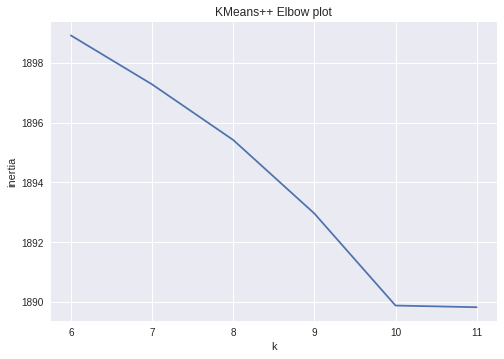

In [6]:
# Plot the ks vs. inertias to try to find any "elbow" 
fig, ax = plt.subplots()
ax.plot(range(6, 12), inertias)
ax.set_xlabel('k')
ax.set_ylabel('inertia')
ax.set_title('KMeans++ Elbow plot')
plt.show()

In [16]:
# let's try k = 10, at one of the kinks
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(vec_summary)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [17]:
clusters = kmeans.predict(vec_summary)
clusters

array([3, 7, 7, ..., 2, 2, 2], dtype=int32)

## Visualization

After performing clustering, we will take the cluster assignments and plot them using SVD. 

Since the document-term matrix is large and sparse, we use an algorithm that can handle sparse matrices.

In [18]:
svd = TruncatedSVD(n_components=2)
vec_2d = svd.fit_transform(vec_summary)
vec_2d

array([[ 0.04795288, -0.04636392],
       [ 0.0610806 , -0.01859464],
       [ 0.06378096, -0.03533575],
       ...,
       [ 0.05272992, -0.05701844],
       [ 0.04447792, -0.05048394],
       [ 0.08167419, -0.08714545]])

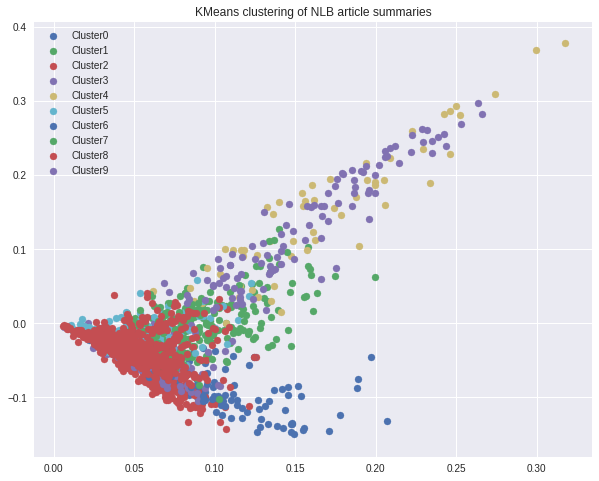

In [19]:
# plot different colours based on clusters

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(k):
    ax.scatter(vec_2d[clusters==i, 0], vec_2d[clusters==i, 1], label=f'Cluster{i}')
    
ax.set_title('KMeans clustering of NLB article summaries')
ax.legend()
plt.show()

## Visual Inspection

We'll use masking to show the summary text of some clusters. 

In [20]:
df['summary'][clusters==1]

11      Masjid Abdul Gaffoor, or Abdul Gaffoor Mosque,...
17      Some of the earliest mentions of Adelphi Hotel...
36      Alkaff Kampung Melayu Mosque, previously known...
37      The Alkaff Lake Gardens was located off MacPhe...
63      Anson Road Stadium, which has been described a...
                              ...                        
1843    The Victoria Theatre and Concert Hall (VTCH) a...
1856    It is believed that Warong Nasi Pariaman is th...
1871    Founded in Calcutta, India by Robert Laidlaw i...
1922    The Young Women’s Christian Association (YWCA)...
1923    Yueh Hai Ching Temple is one of the oldest Tao...
Name: summary, Length: 170, dtype: object

In [21]:
df['summary'][clusters==2]

29      Alex Abisheganaden (b. 31 January 1926, Singap...
41      Amanda Heng Liang Ngim (born 1951, Singapore),...
50      From 1959 up till the early 1960s, Singapore's...
52      Ang Chwee Chai (b. 1910–d. 1995, Singapore) wa...
65      Anthony Poon (b. 21 April 1945, Singapore–d. 2...
                              ...                        
1920    Yong Shu Hoong (b. 1966, Singapore–) is an awa...
1926    Multidisciplinary artist Jailani Zai Kuning (b...
1929    Zhu Xu (朱绪) (b. 15 November 1909, Quanzhou, Fu...
1930    Zouk is a globally renowned award-winning nigh...
1931    Zubir Said (b. 22 July 1907, Bukittinggi, Mina...
Name: summary, Length: 198, dtype: object

In [22]:
df['summary'][clusters==6]

56      Ang Mo Kio Community Library was the fifth ful...
87      Audiovisual Services were first introduced in ...
112     Bedok Public Library, located at 21 Bedok Nort...
149     The Born to Read, Read to Bond programme aimed...
169     Bukit Batok Public Library is located at 1 Buk...
174     Bukit Merah Community Library, located at Buki...
210     Opened on 12 November 1960, the Central Commun...
239     Cheng San Public Library is located in Hougang...
286     Choa Chu Kang Public Library is located in Lot...
297     Christopher Chia (Dr) (b. 1954, Singapore–) is...
336     Community Children’s Libraries (CCLs), targete...
337     Community Libraries are administered by the Na...
503     In 1874, the Singapore Library became a public...
556     Geylang East Community Library (known as Geyla...
558     A collection of 1,000 published books and jour...
624     Hedwig Elizabeth Anuar née Aroozoo (b. 19 Nove...
755     The Junior Library was a library for the young...
761     Jurong

## Topic Extraction

Instead of doing manual visual inspection, a more automated approach is to do "topic extraction" on the clusters.

Topic extraction has benefits in that it also suggests "topic words" so that we don't have to inspect the clusters. Whereas clustering is a general technique that we can use for many things (not just topic extraction).

For each cluster:
 - Use Latent Dirichlet Allocation to extract the top topics
 - Map the top topics to keywords in the documents

References:
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [0]:
# For each cluster, we will run LDA to extract top topics
#
# Effectively, LDA performs the following transformation:
#   document_topic = document_word.dot(topic_word.T)
#
#   The output matrix, document_topic, indicates the topic probabilities
#   for each document. This can be used to extract topics (top topics per doc)
#
#   The components matrix, topic_word, indicates the word probabilities
#   for each topic. This can be used to extract keywords (top words per topic)

def extract_topics(tfidf_transformer, summary_tfidf, num_topics=5):
  topic_names = [f'Topic {i}' for i in range(num_topics)]

  lda = LatentDirichletAllocation(n_components=num_topics)
  topic_probabilities = lda.fit_transform(summary_tfidf)
  
  # get top topic for each document
  # LDA transformation returns document_topic probabilities matrix
  df_document_topic = pd.DataFrame(topic_probabilities)
  top_topics = df_document_topic.values.argmax(axis=1)
  _, counts = np.unique(top_topics, return_counts=True)
  topic_counts = pd.Series(counts, index=topic_names)

  # get topic keywords
  # LDA components contain the topic_word probabilities matrix
  keywords = lda.components_
  df_topic_words = pd.DataFrame(lda.components_, index=topic_names,
                                   columns=tfidf_transformer.get_feature_names())

  return topic_counts, df_topic_words

In [25]:
# Try on cluster 6
cluster_id = 6
topics, keywords = extract_topics(vec, vec_summary[clusters==cluster_id])
topics, keywords

(Topic 0     9
 Topic 1     9
 Topic 2    14
 Topic 3     8
 Topic 4    15
 dtype: int64,
           00  00 pm       000  000 acre  ...   龙灯  龙灯 traditional   龙舞  龙舞 longdeng
 Topic 0  0.2    0.2  0.349703       0.2  ...  0.2             0.2  0.2          0.2
 Topic 1  0.2    0.2  0.275155       0.2  ...  0.2             0.2  0.2          0.2
 Topic 2  0.2    0.2  0.200040       0.2  ...  0.2             0.2  0.2          0.2
 Topic 3  0.2    0.2  0.252470       0.2  ...  0.2             0.2  0.2          0.2
 Topic 4  0.2    0.2  0.254729       0.2  ...  0.2             0.2  0.2          0.2
 
 [5 rows x 79323 columns])

In [26]:
print(f'Top topic for cluster {cluster_id}: {topics.idxmax()}')
# Note that the topic index will change each time we run LDA, because LDA
# is unsupervised. However, the number of topics is fixed.

Top topic for cluster 6: Topic 4


In [27]:
num_keywords = 5
print('Top {num_keywords} topic keywords for cluster {cluster_id}')
keywords.loc[topics.idxmax()].sort_values(ascending=False)[:num_keywords]

Top {num_keywords} topic keywords for cluster {cluster_id}


library             4.384562
national library    1.880011
national            1.417397
libraries           0.844331
located             0.789300
Name: Topic 4, dtype: float64

In [0]:
# let's create a function to get the topic keywords and probabilities

def show_topics(tfidf_transformer, summary_tfidf, cluster_id, num_keywords=5):
  topics, keywords = extract_topics(tfidf_transformer, 
                                    summary_tfidf[clusters==cluster_id])
  top_topic = topics.idxmax()
  print(f'Cluster {cluster_id} topic keywords and probabilities:')
  print(keywords.loc[top_topic].sort_values(ascending=False)[:num_keywords])
  print()

In [29]:
for cluster_id in range(k):
  show_topics(vec, vec_summary, cluster_id)

Cluster 0 topic keywords and probabilities:
party             2.070470
minister          2.013894
lee               1.242232
first             1.023545
prime minister    1.017059
Name: Topic 1, dtype: float64

Cluster 1 topic keywords and probabilities:
building    2.122916
church      1.540762
road        1.331089
temple      1.174533
school      1.174113
Name: Topic 2, dtype: float64

Cluster 2 topic keywords and probabilities:
arts     2.539361
art      1.950928
music    1.843797
award    1.638280
dance    1.616315
Name: Topic 1, dtype: float64

Cluster 3 topic keywords and probabilities:
club           1.458072
association    1.045123
tan            0.970484
mas            0.938419
years          0.861491
Name: Topic 3, dtype: float64

Cluster 4 topic keywords and probabilities:
street             5.132849
road               1.438940
connects           1.086139
mosque             0.983037
street connects    0.953542
Name: Topic 2, dtype: float64

Cluster 5 topic keywords and probab